In [6]:
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np
import ast

In [7]:
dataset_path = os.path.join(Path.cwd().parent, 'data', 'stackexchange_dataset.csv')
data = pd.read_csv(dataset_path,index_col='question_id')
data = data[~data.index.duplicated()]

In [8]:
with open('programmin-langs.txt') as f:
    langs = f.readlines()

# unfortunately :(
langs.append('html')
langs.append('css')

langs = pd.Series(langs).str.strip()
langs = langs.str.extract(r'^([^\(–,]+)')[0].dropna().str.strip()
langs
# langs.values

0           A.NET
1      A-0 System
2              A+
3            ABAP
4             ABC
          ...    
674        Zonnon
675          ZOPL
676           ZPL
677          html
678           css
Name: 0, Length: 679, dtype: object

In [9]:
tags=data[['tags','num_tags']]
tags.loc[:,('tags')] = tags.loc[:,('tags')].apply(ast.literal_eval)

tag_counter = Counter(tag for tags in tags['tags'] for tag in tags)
tag_freq = pd.Series(tag_counter).sort_values(ascending=False)

In [10]:
tag_is_lang = tag_freq.index.str.lower().map(lambda x: langs.str.lower().apply(lambda y: y==x).any())

In [11]:
tag_freq

python            11489
javascript         7369
java               6436
c#                 5215
android            4707
                  ...  
gocardless            1
mosek                 1
aws-powershell        1
radial                1
networkd3             1
Length: 22753, dtype: int64

In [12]:
tresh = 50

In [13]:
selected = tag_freq.iloc[:tresh]
selected.shape

(50,)

In [ ]:
tresh

50

In [ ]:
# selected = tag_freq.iloc[: tresh]
# k_classes = selected.shape[0]

In [14]:
tagged_questions = data[data['tags'].apply(lambda x: any(tag in selected.index for tag in ast.literal_eval(x)))]

In [15]:
tagged_questions.shape

(72514, 11)

Index([ True,  True,  True,  True, False,  True,  True,  True,  True, False,
       ...
       False, False, False, False, False, False, False, False, False, False],
      dtype='bool', length=22753)

In [ ]:
tresholds = np.arange(10, 80, 2)
sizes = []
for tresh in tresholds:
    selected = tag_freq.iloc[:tresh]
    tagged_questions = data[data['tags'].apply(lambda x: any(tag in selected.index for tag in ast.literal_eval(x)))]
    sizes.append(tagged_questions.shape[0])

In [ ]:
tresholds, sizes

(array([  10,  110,  210,  310,  410,  510,  610,  710,  810,  910, 1010,
        1110, 1210, 1310, 1410, 1510, 1610, 1710, 1810, 1910, 2010]),
 [45462,
  81418,
  86378,
  88742,
  90195,
  91503,
  92469,
  93220,
  93707,
  94160,
  94571,
  94991,
  95323,
  95647,
  95875,
  96056,
  96237,
  96466,
  96621,
  96749,
  96919])

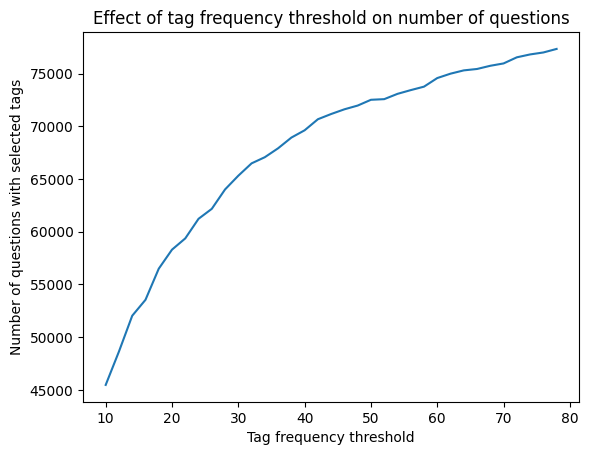

In [ ]:
sns.lineplot(x=tresholds, y=sizes)
plt.xlabel('Tag frequency threshold')
plt.ylabel('Number of questions with selected tags')
plt.title('Effect of tag frequency threshold on number of questions')
plt.show()

---

Tag embedding

In [ ]:
import ollama
BATCH_SIZE = 100
model = 'qwen3-embedding'

In [ ]:
data_for_embedding = data[['tags']]
data_for_embedding.loc[:,('tags')] = data_for_embedding.loc[:,('tags')].apply(ast.literal_eval)
data_for_embedding

,tags
question_id,
79802517,"[c#, entity-framework]"
79802934,[ntp]
79802909,"[python, pandas]"
79802932,"[database, mongodb, nosql, system-administration]"
79802919,"[c++, qt, qml, vulkan]"
...,...
79662126,[javascript]
79662912,"[machine-learning, deep-learning, artificial-i..."
79663172,"[html, pdf]"


In [ ]:
tags = data_for_embedding['tags'].explode().unique()
tags = tags.tolist()
tags

['c#',
 'entity-framework',
 'ntp',
 'python',
 'pandas',
 'database',
 'mongodb',
 'nosql',
 'system-administration',
 'c++',
 'qt',
 'qml',
 'vulkan',
 'spring-boot',
 'apache-kafka',
 'spring-kafka',
 'jvm-arguments',
 'flutter',
 'dart',
 'java',
 'apache-commons-collection',
 'artificial-intelligence',
 'jupyter-notebook',
 'hyperlink',
 'markdown',
 'jupyter',
 'performance',
 'parallel-processing',
 'decode',
 'sql',
 'sql-server',
 'union',
 'temp-tables',
 'php',
 'html',
 'textarea',
 'google-merchant-center',
 'node.js',
 'angular',
 'express',
 'socket.io',
 'sony',
 'robot',
 'elasticsearch',
 'logstash',
 'kibana',
 'intellij-idea',
 'entity-framework-core',
 'lazy-loading',
 'clr',
 'background-service',
 'javascript',
 'websocket',
 'async-await',
 'stripe-payments',
 'stripe-payments-js',
 'http-redirect',
 'drupal',
 'composer-php',
 'firebase',
 'kotlin',
 'google-cloud-vertex-ai',
 'firebase-ai-logic',
 'spring',
 'jvm',
 'git',
 'git-lfs',
 'power-automate',
 'vnet

In [16]:
tag_embeddings = {}

In [17]:
from tqdm import tqdm

In [18]:
# tags[0:10]

In [19]:
# for i in tqdm(range(0, len(tags), BATCH_SIZE)):
#     batch_texts = tags[i:i + BATCH_SIZE]
#     result = ollama.embed(
#             model=model,
#             input=batch_texts
#         )
#     batch_embeddings = [np.array(e) for e in result['embeddings']]
#     tag_embeddings.update(dict(zip(batch_texts, batch_embeddings)))

In [20]:
tags_df = pd.DataFrame()
tags_df['tag'] = tag_embeddings.keys()
tags_df['embedding'] = tag_embeddings.values()
tags_df.index = tags_df['tag']
tags_df.drop(columns=['tag'], inplace=True)
tags_df

,embedding
tag,


In [21]:
# tags_df.to_parquet('tag_embeddings.parquet')
tags_df = pd.read_parquet(os.path.join(Path.cwd().parent, 'data', 'tag_embeddings.parquet'))
tags_df2 = tags_df.copy()

In [22]:
tags_df

,embedding
tag,
c#,"[0.015589412, 0.0028190461, -0.02159284, -0.00..."
entity-framework,"[0.013604954, -0.017427877, 0.008887872, -0.02..."
ntp,"[0.0025991949, 0.020412365, -0.025822664, -0.0..."
python,"[0.0044617336, 0.017571222, -0.028520588, -0.0..."
pandas,"[0.013557544, 0.023968168, -0.04845796, -0.009..."
...,...
gocardless,"[0.031818543, 0.0014768182, 0.0064690523, -0.0..."
daxstudio,"[0.01692661, -0.008786624, -0.008296905, -0.02..."
woocommerce-email,"[0.032131393, -0.0161308, 0.029701, 0.01068102..."


In [23]:
combined_emb= data[['tags','num_tags']]
combined_emb.loc[:,('tags')] = combined_emb.loc[:,('tags')].apply(ast.literal_eval)
combined_emb

,tags,num_tags
question_id,,
79802517,"[c#, entity-framework]",2
79802934,[ntp],1
79802909,"[python, pandas]",2
79802932,"[database, mongodb, nosql, system-administration]",4
79802919,"[c++, qt, qml, vulkan]",4
...,...,...
79662126,[javascript],1
79662912,"[machine-learning, deep-learning, artificial-i...",3
79663172,"[html, pdf]",2


In [24]:
embeddings_list= []

for row in combined_emb['tags']:
    embeddings_list.append(tags_df.loc[row]['embedding'].mean())

KeyboardInterrupt: 

In [ ]:
combined_emb['embeddings'] = embeddings_list
combined_emb

/tmp/ipykernel_139429/2252903474.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_emb['embeddings'] = embeddings_list


,tags,num_tags,embeddings
question_id,,,
79802517,"[c#, entity-framework]",2,"[0.014597183, -0.007304415450000001, -0.006352..."
79802934,[ntp],1,"[0.0025991949, 0.020412365, -0.025822664, -0.0..."
79802909,"[python, pandas]",2,"[0.0090096388, 0.020769695, -0.038489274000000..."
79802932,"[database, mongodb, nosql, system-administration]",4,"[0.021165110125, -0.0024636488499999998, -0.01..."
79802919,"[c++, qt, qml, vulkan]",4,"[0.0282386215, 0.012680247750000002, 0.0094472..."
...,...,...,...
79662126,[javascript],1,"[0.038955722, 0.026670303, -0.023417698, -0.03..."
79662912,"[machine-learning, deep-learning, artificial-i...",3,"[0.030834721666666665, 0.028821177333333337, -..."
79663172,"[html, pdf]",2,"[0.011843098049999999, 0.0084187835, -0.000395..."


In [27]:
# combined_emb.to_parquet(os.path.join(Path.cwd().parent, 'data', 'questions_with_tag_embeddings.parquet'))
combined_emb = pd.read_parquet(os.path.join(Path.cwd().parent, 'data', 'questions_with_tag_embeddings.parquet'))

In [28]:
from sklearn.metrics import calinski_harabasz_score
from sklearn.cluster import KMeans

In [29]:
km = KMeans(n_clusters=10, random_state=42)
km.fit(np.vstack(combined_emb['embeddings'].values))

,n_clusters,10
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,42
,copy_x,True
,algorithm,'lloyd'


In [30]:
km.labels_

array([0, 1, 7, ..., 3, 1, 8], shape=(99992,), dtype=int32)

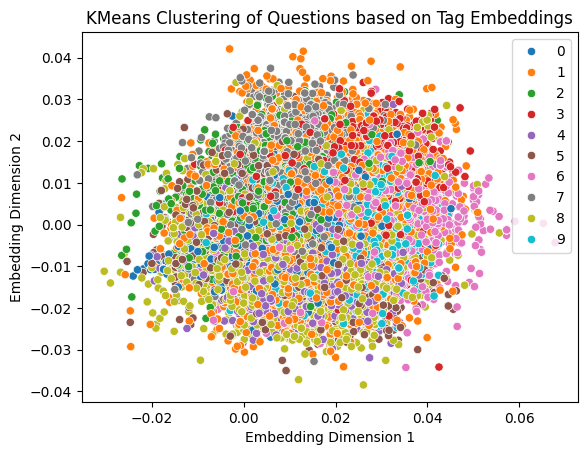

In [31]:
sns.scatterplot(x=np.vstack(combined_emb['embeddings'].values)[:,0], y=np.vstack(combined_emb['embeddings'].values)[:,1], hue=km.labels_, palette='tab10')
plt.title('KMeans Clustering of Questions based on Tag Embeddings')
plt.xlabel('Embedding Dimension 1')
plt.ylabel('Embedding Dimension 2')
plt.show()

In [35]:
combined_emb.head(2)

,tags,num_tags,embeddings
question_id,,,
79802517,"[c#, entity-framework]",2,"[0.014597183, -0.007304415450000001, -0.006352..."
79802934,[ntp],1,"[0.0025991949, 0.020412365, -0.025822664, -0.0..."


In [36]:
kmeans_results = pd.DataFrame()
kmeans_results['question_id'] = combined_emb.index
kmeans_results.index = combined_emb.index
kmeans_results.drop(columns=['question_id'], inplace=True)
kmeans_results['kmeans_label'] = km.labels_
kmeans_results['tags'] = combined_emb['tags']
kmeans_results

,kmeans_label,tags
question_id,,
79802517,0,"[c#, entity-framework]"
79802934,1,[ntp]
79802909,7,"[python, pandas]"
79802932,4,"[database, mongodb, nosql, system-administration]"
79802919,1,"[c++, qt, qml, vulkan]"
...,...,...
79662126,3,[javascript]
79662912,7,"[machine-learning, deep-learning, artificial-i..."
79663172,3,"[html, pdf]"


In [39]:
df_exploded = kmeans_results.explode('tags')
df_exploded = df_exploded.rename(columns={'tags': 'tag'})

In [40]:
cluster_size = kmeans_results.groupby('kmeans_label').size().reset_index(name='document_count')
cluster_size

,kmeans_label,document_count
0,0,7368
1,1,21620
2,2,7786
3,3,8317
4,4,5674
5,5,4820
6,6,8739
7,7,11618
8,8,14381
9,9,9669


In [42]:
# sns.histplot(data=df_exploded, x='kmeans_label', discrete=True)

In [45]:
summary_metrics

,kmeans_label,document_count,unique_tag_count,total_tags_count
0,0,7368,3109,23816
1,1,21620,9432,67979
2,2,7786,3237,25163
3,3,8317,2787,26087
4,4,5674,2171,15721
5,5,4820,1988,15244
6,6,8739,3199,27581
7,7,11618,4058,37029
8,8,14381,6318,40870
9,9,9669,3904,31557


In [ ]:
score = calinski_harabasz_score(np.vstack(combined_emb['embeddings'].values), km.labels_)

In [ ]:
score

3108.1156055082165

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
model = PCA(n_components=2)
pca_result = model.fit_transform(np.vstack(combined_emb['embeddings'].values))

<Axes: >

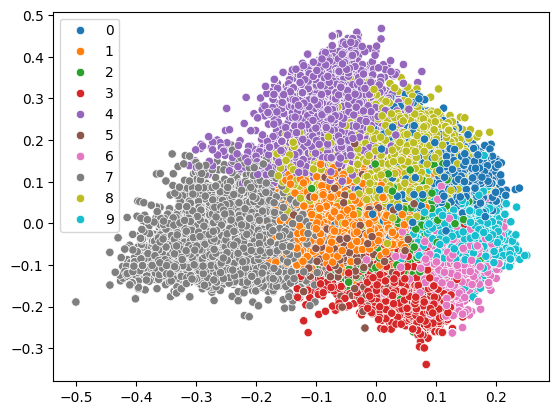

In [ ]:
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1], hue=km.labels_, palette='tab10')

---

In [62]:
from umap import UMAP

/home/hevagog/Studies/advanced-data-mining/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
ump = UMAP(n_components=2, metric='cosine')

In [ ]:
reduced_embeddings = ump.fit_transform(np.vstack(combined_emb['embeddings'].values))

/home/hevagog/Studies/advanced-data-mining/.venv/lib/python3.13/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/hevagog/Studies/advanced-data-mining/.venv/lib/python3.13/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/hevagog/Studies/advanced-data-mining/.venv/lib/python3.13/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


<Axes: >

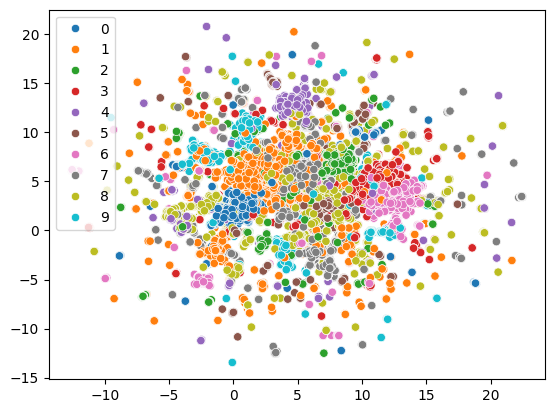

In [ ]:
sns.scatterplot(x=reduced_embeddings[:,0], y=reduced_embeddings[:,1], hue=km.labels_, palette='tab10')

---

## Working on a subset of data

In [50]:
combined_emb.head(2)

,tags,num_tags,embeddings
question_id,,,
79802517,"[c#, entity-framework]",2,"[0.014597183, -0.007304415450000001, -0.006352..."
79802934,[ntp],1,"[0.0025991949, 0.020412365, -0.025822664, -0.0..."


In [57]:
emb_subset = combined_emb.sample(frac=0.3, random_state=42)
emb_subset.head(2)

,tags,num_tags,embeddings
question_id,,,
69776611,"[python, binary]",2,"[0.0140591668, 0.013375569, -0.015017379649999..."
79771526,"[swift, swiftui, ios26, liquid-glass]",4,"[0.014125214399999999, -0.0016669680250000001,..."


In [58]:
emb_subset

,tags,num_tags,embeddings
question_id,,,
69776611,"[python, binary]",2,"[0.0140591668, 0.013375569, -0.015017379649999..."
79771526,"[swift, swiftui, ios26, liquid-glass]",4,"[0.014125214399999999, -0.0016669680250000001,..."
51257356,"[windows, powershell, windows-server-2012, pow...",5,"[-0.0073406572000000005, -0.009446224999999999..."
79791602,"[javascript, reactjs, react-router, react-rout...",5,"[0.022934320700000004, 0.008868541879999999, -..."
52701004,"[jquery, jquery-select2]",2,"[0.02499304, 0.0038376545, 0.00786952428, -0.0..."
...,...,...,...
52859667,"[html, r, web-scraping, rvest]",4,"[0.018415329324999997, 0.0054339783, -0.014440..."
54963248,[reactjs],1,"[0.030073853, 0.00365843, -0.048054054, -0.034..."
79679466,"[css, payload, shadcnui]",3,"[0.012583419066666665, 0.013155190000000002, -..."


In [59]:
from sklearn.cluster import HDBSCAN

In [60]:
hdbscan_model = HDBSCAN(min_cluster_size=15, metric='cosine')

In [61]:
hdbscan_model.fit(np.vstack(emb_subset['embeddings'].values))

,min_cluster_size,15
,min_samples,None
,cluster_selection_epsilon,0.0
,max_cluster_size,None
,metric,'cosine'
,metric_params,None
,alpha,1.0
,algorithm,'auto'
,leaf_size,40
,n_jobs,None
,cluster_selection_method,'eom'


In [64]:
ump_2 = UMAP(n_components=2, metric='cosine')
reduced_embeddings = ump_2.fit_transform(np.vstack(emb_subset['embeddings'].values))

/home/hevagog/Studies/advanced-data-mining/.venv/lib/python3.13/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


In [67]:
labels = hdbscan_model.labels_

<Axes: ylabel='Count'>

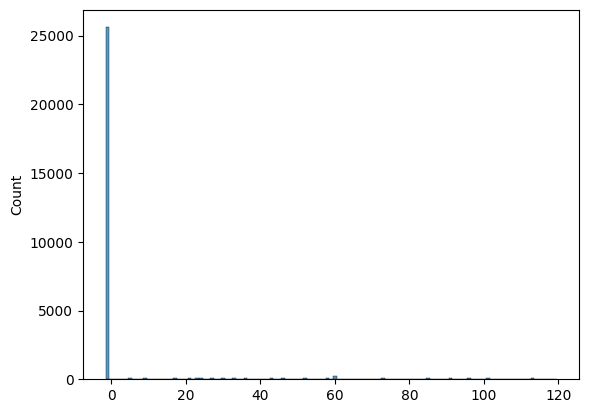

In [68]:
sns.histplot(data=labels, discrete=True)